In [77]:
import pandas as pd
import numpy as np
import geocoder
import folium
from folium.plugins import MarkerCluster
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from bs4 import BeautifulSoup
import requests

## Scraping a Moscow Metro stations data 

In [78]:
results = []
url = r'https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations'
wikipage = requests.get(url)
sup = BeautifulSoup(wikipage.text, 'lxml')
wtable = sup.find('table', attrs={'class':'wikitable sortable'})
body = wtable.find('tbody')
rows = body.find_all('tr')
for row in rows:
        table_data = row.find_all('td')
        if table_data:
            results.append([data.get_text(strip = True) for data in table_data])
            
df = pd.DataFrame(results)
df

,0,1,2,3,4,5,6,7
0,Bulvar Rokossovskogo,Бульвар Рокоссовского,<>,1990-08-01,−8 m,"column, triple-span",55°48′53″N37°44′03″E﻿ / ﻿55.8148°N 37.7342°E﻿ ...,None
1,Cherkizovskaya,Черкизовская,{},1990-08-01,−9 m,"single-vault, shallow",55°48′14″N37°44′41″E﻿ / ﻿55.8038°N 37.7448°E﻿ ...,None
2,Preobrazhenskaya Ploshchad,Преображенская площадь,,1965-12-31,−8 m,"column, triple-span",55°47′47″N37°42′54″E﻿ / ﻿55.7963°N 37.7151°E﻿ ...,None
3,Sokolniki,Сокольники,,1935-05-15,−9 m,"column, triple-span",55°47′20″N37°40′49″E﻿ / ﻿55.7888°N 37.6802°E﻿ ...,None
4,Krasnoselskaya,Красносельская,,1935-05-15,−8 m,"column, double-span",55°46′48″N37°40′02″E﻿ / ﻿55.7801°N 37.6673°E﻿ ...,None
...,...,...,...,...,...,...,...,...
266,Yugo-Vostochnaya,Юго-Восточная,,2020-03-27,,,,None
267,Kosino,Косино,,2019-06-03,−18 m,"column, triple-span",55°42′12″N37°51′04″E﻿ / ﻿55.7033°N 37.8511°E﻿ ...,None
268,Ulitsa Dmitriyevskogo,Улица Дмитриевского,,2019-06-03,,"column, double-span",55°42′36″N37°52′45″E﻿ / ﻿55.7100°N 37.8792°E﻿ ...,None
269,Lukhmanovskaya,Лухмановская,,2019-06-03,,"column, triple-span",55°42′31″N37°54′01″E﻿ / ﻿55.7085°N 37.9004°E﻿ ...,None


### Cleaning metro stations data

In [79]:
df = df[[0,1,6]] # we only need the station name in Russian and English and coordinates for each station
df.rename(columns = {0:'Station', 1: 'Russian', 6:'coordinates'}, inplace = True)
df.coordinates = df.coordinates.replace('', np.nan) # some stations may don't contain coords, replace the empty strings to NaN
df.coordinates = df.coordinates.str.replace(r'(\S*\s\/\s)|\s\/(\s|\S)*|°N|°E', '') # save only the coordinates in the format like '55.8412 37.2288'
df.coordinates = df.coordinates.str.replace(u'\ufeff', '')# delete BOM
df[['Latitude','Longitude']] = df.coordinates.str.split(' ', expand = True) # create columns for lat and lng
df = df.drop(columns = 'coordinates')# now we don't need this column
df = df.drop_duplicates(subset = 'Station').reset_index(drop = True) # some lines have multiple stations with the same names. this happens at intersections of lines
missed = df[df.isnull().T.any().T] # find rows with NaN values
missed 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,Station,Russian,Latitude,Longitude
22,Filatov Lug,Филатов Луг,NaN,NaN
23,Prokshino,Прокшино,NaN,NaN
24,Olkhovaya,Ольховая,NaN,NaN
25,Kommunarka,Коммунарка,NaN,NaN
232,Lefortovo,Лефортово,NaN,NaN
233,Stakhanovskaya,Стахановская,NaN,NaN
234,Okskaya,Окская,NaN,NaN
235,Yugo-Vostochnaya,Юго-Восточная,NaN,NaN


<details>
  <summary>Spoiler</summary>
  
  I need to delete the first three rows (Filatov lug, Prokshino and Olkhovaya) because there are some errors when the Foursquare API finds data about nearby venues. Quite often, the next search list of establishments will differ from the previous one for stations Filatov Lug and Prokshino. And for Olkhovaya station, establishments are similar to those of Kommunarka station. Most likely, this is due to the lack of a sufficient number of establishments within a radius of 900 meters from these stations. 
  
</details>

In [80]:
# find missing coordinates wtih geocoder library
for i, st in zip(missed.index.tolist()[3:], missed['Station'].values[3:]):
    address = '{} metro, Moscow, Russia'.format(st)
    location = geocoder.arcgis(address)
    df.iloc[i,[2,3]] = location.latlng[0], location.latlng[1]
df = df.dropna().reset_index(drop = True)
df

,Station,Russian,Latitude,Longitude
0,Bulvar Rokossovskogo,Бульвар Рокоссовского,55.8148,37.7342
1,Cherkizovskaya,Черкизовская,55.8038,37.7448
2,Preobrazhenskaya Ploshchad,Преображенская площадь,55.7963,37.7151
3,Sokolniki,Сокольники,55.7888,37.6802
4,Krasnoselskaya,Красносельская,55.7801,37.6673
...,...,...,...,...
232,Yugo-Vostochnaya,Юго-Восточная,55.7058,37.8173
233,Kosino,Косино,55.7033,37.8511
234,Ulitsa Dmitriyevskogo,Улица Дмитриевского,55.7100,37.8792
235,Lukhmanovskaya,Лухмановская,55.7085,37.9004


## Collecting data about passenger traffic per Station


In [81]:
traffic_list = []
lines = ['1','2', '3', '4', '5', '6', '7', '8', '8a', '9','10', '11','12', '15'] # list with names of lines Moscow Metro
for line in lines:
    test_scrap_url = r'http://www.metro-msk.ru/stancii-metro/liniya-{}/'.format(line)
    metropage = requests.get(test_scrap_url)
    page = BeautifulSoup(metropage.text, 'lxml')
    tables = page.find_all('table')
    for table in tables[1:]:
        rows = table.find_all('tr')
        for row in rows:
            table_data = row.find_all(('a', 'font'), {'class' : not 'link2'})
            if table_data:
                traffic_list.append([data.get_text(strip = True) for data in table_data])


### Cleaning traffic data

In [82]:
traffic_df = pd.DataFrame(traffic_list).rename(columns = {0: 'Russian', 1: 'Traffic'})
traffic_df = traffic_df.dropna().reset_index(drop = True)
traffic_df.Traffic = traffic_df.Traffic.str.replace(r'\s\S*', '') #
traffic_df['Traffic'] = traffic_df['Traffic'].astype('float64')
traffic_df['Traffic'] *= 1000
traffic_df.Russian = traffic_df.Russian.str.replace('ё', 'е')
traffic_df

,Russian,Traffic
0,Бульвар Рокоссовского,30800.0
1,Черкизовская,25900.0
2,Преображенская площадь,50800.0
3,Сокольники,75400.0
4,Красносельская,25100.0
...,...,...
210,Улица Старокачаловская,6500.0
211,Улица Скобелевская,17200.0
212,Бульвар Адмирала Ушакова,2600.0
213,Улица Горчакова,12400.0


## Getting price per station data

In [83]:
prices = []
price_url = r'https://www.mirkvartir.ru/journal/analytics/2019/09/01/Polnyj-rejting-stancij-metro-Moskvy-po-stoimosti-kvartir/'
price = requests.get(price_url)
sup2 = BeautifulSoup(price.text, 'lxml')
tbody = sup2.find('tbody')
rows = tbody.find_all('tr')
for row in rows[1:]:
        table_data = row.find_all('td')
        if table_data:
            prices.append([data.get_text(strip = True) for data in table_data])

### Cleaning price data

In [84]:
# we need columns 1 and 2, rename them
price_df = pd.DataFrame(prices).rename(columns = { 1:'Russian', 2: 'Price(RUR/sqm)'})
# some stations name has different letter case, fixing it
replacers = {'ё': 'е','Культуры':'культуры', ' Поле':' поле', 'адмирала':'Адмирала', 'роща':'Роща', 'Филатов луг': 'Филатов Луг' }
for x,y in replacers.items():
    price_df.Russian = price_df.Russian.str.replace(x, y)
price_df['Price(RUR/sqm)'] =price_df['Price(RUR/sqm)'].str.replace(' ', '') #
price_df['Price(RUR/sqm)'] = price_df['Price(RUR/sqm)'].astype('float64')

In [85]:
price_df

,0,Russian,Price(RUR/sqm),3,4,5
0,1,Кропоткинская,492846.0,"7,7%",36126805,"8,8%"
1,2,Охотный ряд,472369.0,"3,2%",35768476,"5,3%"
2,3,Площадь Революции,472369.0,"3,2%",35768476,"5,3%"
3,4,Театральная,472369.0,"3,2%",35768476,"5,3%"
4,5,Пушкинская,470822.0,"6,8%",33025865,"7,4%"
...,...,...,...,...,...,...
207,208,Прокшино,140023.0,н. д.,7601982,н. д.
208,209,Лухмановская,137442.0,н. д.,7484346,н. д.
209,210,Филатов Луг,134034.0,н. д.,7090243,н. д.
210,211,Некрасовка,133680.0,н. д.,7328632,н. д.


## Acquisition and cleaning metro per district data

In [86]:
list_st = []
list_url = r'https://metro.mwmoskva.ru/stancii-spisok/po_rajonam/'
st = requests.get(list_url)
soup_st = BeautifulSoup(st.text, 'lxml')
divs = soup_st.find_all('div', attrs={'class':'list-title'})
uls = soup_st.find_all('ul', attrs={'class':'list-content'})
#rows = tbody.find_all('tr')
for div, ul in zip(divs[1:], uls[1:]):
    ul_data = ul.find_all('div', attrs={'class':'list-name'})
    for u in ul_data:
        list_st.append([div.get_text(strip = True),u.get_text(strip = True)])
distr_df = pd.DataFrame(list_st)
distr_df = distr_df.rename(columns = {0:'District', 1:'Russian'})
distr_df['District'] = distr_df['District'].str.replace(r'\S+\s', '')


In [87]:
# Bringing district names to a single version. This is necessary for later merging
distr_df['District'] = distr_df['District'].str.replace(r'Левобережном', 'Левобережный')
distr_df['District'] = distr_df['District'].str.replace(r'ком', 'кий')
distr_df['District'] = distr_df['District'].str.replace(r'ках', 'ки')
distr_df['District'] = distr_df['District'].str.replace(r'ке', 'ка')
distr_df['District'] = distr_df['District'].str.replace(r'Арбате', 'Арбат')
distr_df['Russian'] = distr_df['Russian'].str.replace(r'шоссе', 'Шоссе')
distr_df

,District,Russian
0,Академический,Академическая
1,Алексеевский,Алексеевская
2,Арбат,Александровский сад
3,Арбат,Арбатская
4,Арбат,Арбатская
...,...,...
341,Якиманка,Полянка
342,Ясенево,Битцевский парк
343,Ясенево,Новоясеневская
344,Ясенево,Теплый стан


### Acquisition and cleaning eco data

In [88]:
eco_st = []
eco_url = r'https://www.novostroy-m.ru/analitika/ekologicheskiy_reyting_rayonov_moskvy'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
eco = requests.get(eco_url,  proxies={'http':'50.207.31.221:80'}, headers = headers)
soup_eco = BeautifulSoup(eco.text)
eco_body = soup_eco.find('tbody')
rows = eco_body.find_all('tr')
for row in rows:
    row_data = row.find_all('td')
    eco_st.append(data.get_text(strip = True) for data in row_data)
eco_df = pd.DataFrame(eco_st)
eco_df = eco_df.rename(columns = {0:'District', 1:'Neighborhood', 2:'Rating'})
eco_df = eco_df.dropna().reset_index(drop = True)
# And again, bringing district names to a single version
eco_df['District'] = eco_df['District'].str.replace(r'кое\S\s\S*', 'кий')
eco_df['District'] = eco_df['District'].str.replace(r'-П', 'п')
eco_df['District'] = eco_df['District'].str.replace(r'Преображенское', 'Преображенский')
eco_df

,District,Neighborhood,Rating
0,Косино-Ухтомский,ВАО,1
1,Преображенский,ВАО,1
2,Соколиная Гора,ВАО,1
3,Богородское,ВАО,2
4,Вешняки,ВАО,2
...,...,...,...
141,Первомайский,Троицкий округ,3
142,Роговский,Троицкий округ,3
143,Щаповский,Троицкий округ,3
144,Вороновский,Троицкий округ,4


In [89]:
# location of Moscow city
address = 'Moscow'
location = geocoder.arcgis(address)
print('The geograpical coordinate of Moscow are {:.6}, {:.6}.'.format(location.latlng[0], location.latlng[1]))

The geograpical coordinate of Moscow are 55.757, 37.615.


In [91]:
# Creating a map and adding markers to it
map_moscow = folium.Map(location=location.latlng, zoom_start=10)

# add markers to map
for lat, lng, metro in zip(df['Latitude'],df['Longitude'], df['Station']):
    label = '{}'.format(metro)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow) 
    
    
map_moscow

## Collecting data about nearby venues

In [92]:
# constant parameters for API request
VERSION = '202004126'
radius = 900
LIMIT = 300

In [93]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
venues_df = getNearbyVenues(names = df['Station'], 
                latitudes = df['Latitude'], 
                longitudes = df['Longitude'])

Bulvar Rokossovskogo
Cherkizovskaya
Preobrazhenskaya Ploshchad
Sokolniki
Krasnoselskaya
Komsomolskaya
Krasnye Vorota
Chistyye Prudy
Lubyanka
Okhotny Ryad
Biblioteka Imeni Lenina
Kropotkinskaya
Park Kultury
Frunzenskaya
Sportivnaya
Vorobyovy Gory
Universitet
Prospekt Vernadskogo
Yugo-Zapadnaya
Troparyovo
Rumyantsevo
Salaryevo
Kommunarka
Khovrino
Belomorskaya
Rechnoy Vokzal
Vodny Stadion
Voykovskaya
Sokol
Aeroport
Dinamo
Belorusskaya
Mayakovskaya
Tverskaya
Teatralnaya
Novokuznetskaya
Paveletskaya
Avtozavodskaya
Tekhnopark
Kolomenskaya
Kashirskaya
Kantemirovskaya
Tsaritsyno
Orekhovo
Domodedovskaya
Krasnogvardeyskaya
Alma-Atinskaya
Pyatnitskoye Shosse
Mitino
Volokolamskaya
Myakinino
Strogino
Krylatskoye
Molodyozhnaya
Kuntsevskaya
Slavyansky Bulvar
Park Pobedy
Kiyevskaya
Smolenskaya
Arbatskaya
Ploshchad Revolyutsii
Kurskaya
Baumanskaya
Elektrozavodskaya
Semyonovskaya
Partizanskaya
Izmaylovskaya
Pervomayskaya
Shchyolkovskaya
Pionerskaya
Filyovsky Park
Bagrationovskaya
Fili
Kutuzovskaya
Stude

In [20]:
print('There are {} unique categories.'.format(len(venues_df['Venue Category'].unique())))

There are 369 unique categories.


In [95]:
# Since the fusion restaurant includes various cuisines of the world, restaurants of certain cuisines will compete
# But first, need to remove the 'restaurant' from fast food establishments
venues_df['Venue Category'] = venues_df['Venue Category'].str.replace(r'Fast [F|f]ood\s?\S*','Fast Food')
venues_df['Venue Category'] = venues_df['Venue Category'].str.replace(r'\S*\s?\S*\s?[r|R]estaurant', 'Restaurant')
venues_df['Venue Category'] = venues_df['Venue Category'].str.replace('Noodle House','Restaurant') # In Russia, very often Noodle Houses are Asian restaurants

In [96]:
venues_df

,Station,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bulvar Rokossovskogo,55.8148,37.7342,Ветеринарная Аптека Ветлек,55.813464,37.735036,Pet Store
1,Bulvar Rokossovskogo,55.8148,37.7342,Подружка,55.814523,37.736781,Cosmetics Shop
2,Bulvar Rokossovskogo,55.8148,37.7342,Burger King,55.814026,37.733659,Fast Food
3,Bulvar Rokossovskogo,55.8148,37.7342,Галерея Богородское,55.813944,37.734298,Art Gallery
4,Bulvar Rokossovskogo,55.8148,37.7342,Фо & Ролл,55.815955,37.736421,Restaurant
...,...,...,...,...,...,...,...
7099,Nekrasovka,55.7036,37.9264,Spar,55.702024,37.931869,Supermarket
7100,Nekrasovka,55.7036,37.9264,Пятерочка,55.705883,37.931672,Supermarket
7101,Nekrasovka,55.7036,37.9264,Оранж,55.704874,37.921627,Convenience Store
7102,Nekrasovka,55.7036,37.9264,Burger King,55.702128,37.931995,Fast Food


In [97]:
# Heat map for 
rests = venues_df[venues_df['Venue Category']=='Restaurant']

res_heat = folium.Map(location=location.latlng, zoom_start=11)
folium.plugins.HeatMap(list(zip(rests['Venue Latitude'],rests['Venue Longitude'])),
        min_opacity=0.2,
        radius=10, blur=15,
        max_zoom=1
       ).add_to(res_heat)
for lat, lng, label in zip(rests['Latitude'], rests['Longitude'], rests['Station']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(res_heat)
res_heat

##### Looking at the map, you can assume that the most attractive areas will be located closer to the outskirts of the city

## Preparing data for clustering

In [98]:
onehot = pd.get_dummies(venues_df['Venue Category'], prefix="", prefix_sep="")

onehot['Station'] = venues_df['Station'] 

fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
onehot

,Station,ATM,Accessories Store,Adult Boutique,Amphitheater,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Watch Shop,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Bulvar Rokossovskogo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bulvar Rokossovskogo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bulvar Rokossovskogo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bulvar Rokossovskogo,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bulvar Rokossovskogo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7099,Nekrasovka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7100,Nekrasovka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7101,Nekrasovka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7102,Nekrasovka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


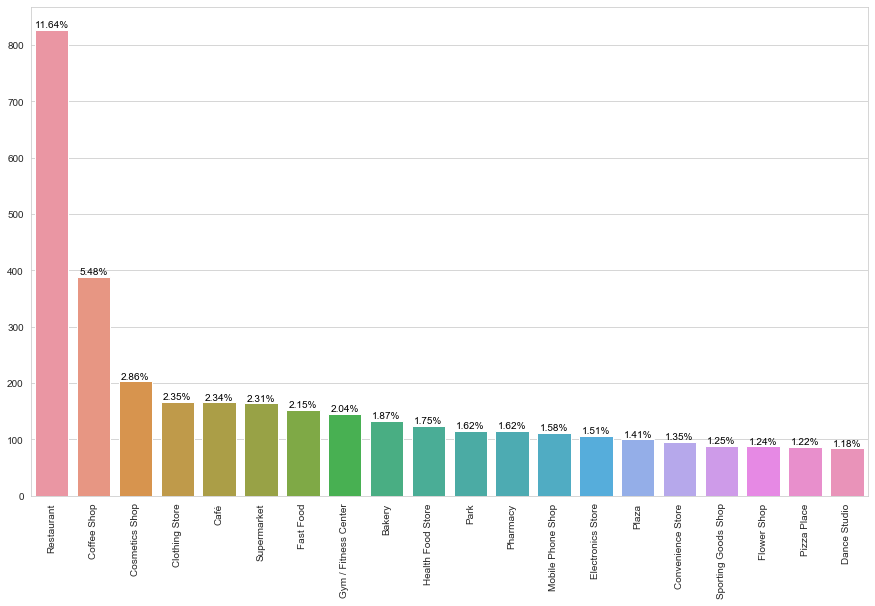

In [99]:
percents = [i/plotdf.values.sum()* 100 for i in plotdf.values]
fig = plt.figure(figsize = (15, 9))
sns.set_style('whitegrid')
plotdf = onehot.groupby('Station').sum().sum()
plotdf = plotdf.sort_values(ascending = False).head(20)
chart = sns.barplot(x=plotdf.index, y=plotdf.values)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
for xtick in chart.get_xticks():
    chart.text(xtick, plotdf.values[xtick]+4, '{}%'.format(round(percents[xtick], 2)), horizontalalignment='center',size=10,color='black')
plt.show()
plotdf = onehot.groupby('Station').sum().sum().sort_values(ascending = False)
percents = [i/plotdf.values.sum()* 100 for i in plotdf.values]

In [100]:
grouped = onehot.groupby('Station').mean().reset_index()
grouped

,Station,ATM,Accessories Store,Adult Boutique,Amphitheater,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Watch Shop,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Aeroport,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.017857,0.0,0.0,0.0,0.0,0.0
1,Akademicheskaya,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.020833,0.000000,0.0,0.0,0.0,0.0,0.0
2,Aleksandrovsky Sad,0.0,0.0,0.0,0.0,0.0,0.000000,0.051282,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,Alekseyevskaya,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.028571,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,Alma-Atinskaya,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.083333,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,Yuzhnaya,0.0,0.0,0.0,0.0,0.0,0.029412,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
233,ZIL,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
234,Zhulebino,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
235,Zorge,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [101]:
num_top_venues = 10

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top = pd.DataFrame(columns=columns)
top['Station'] = grouped['Station']

for ind in np.arange(grouped.shape[0]):
    top.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

top

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aeroport,Coffee Shop,Café,Cosmetics Shop,Restaurant,Convenience Store,Deli / Bodega,Flower Shop,Food & Drink Shop,Farmers Market,Gym / Fitness Center
1,Akademicheskaya,Restaurant,Pharmacy,Health Food Store,Coffee Shop,Park,Beer Store,Grocery Store,Pizza Place,Bookstore,Music Store
2,Aleksandrovsky Sad,Restaurant,Concert Hall,Coffee Shop,Plaza,Park,Science Museum,Museum,Art Gallery,Beer Bar,Event Space
3,Alekseyevskaya,Toy / Game Store,Hobby Shop,Coffee Shop,Health Food Store,Restaurant,Food & Drink Shop,Pet Store,Gourmet Shop,Mobile Phone Shop,Gift Shop
4,Alma-Atinskaya,Gym,Playground,Metro Station,Tennis Stadium,Health Food Store,Supermarket,Arts & Crafts Store,Park,Convenience Store,Pharmacy
...,...,...,...,...,...,...,...,...,...,...,...
232,Yuzhnaya,Restaurant,Fast Food,Sports Bar,Supermarket,Shopping Mall,Pool Hall,Monument / Landmark,Blini House,Clothing Store,Supplement Shop
233,ZIL,Sporting Goods Shop,Hockey Arena,Park,Pool,Zoo Exhibit,Flea Market,Field,Film Studio,Financial or Legal Service,Fish Market
234,Zhulebino,Supermarket,Cosmetics Shop,Convenience Store,Sporting Goods Shop,Coffee Shop,Fast Food,Restaurant,Park,Bookstore,Pet Store
235,Zorge,Music Venue,Auto Dealership,Auto Workshop,Restaurant,Gymnastics Gym,Martial Arts Dojo,Vegetarian Restaurant,Film Studio,Financial or Legal Service,Fish Market


### Try to find best 'k' with the Elbow method

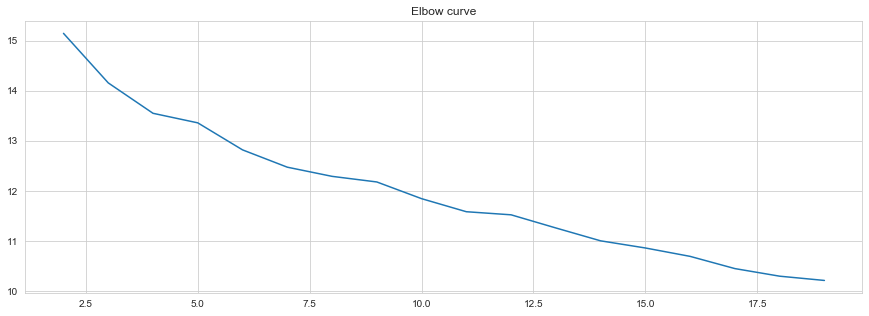

In [102]:

km = grouped.drop('Station', 1)

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

X = km
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

##### It is difficult to draw any conclusions from this plot. So, i think, need to use silhouette score method

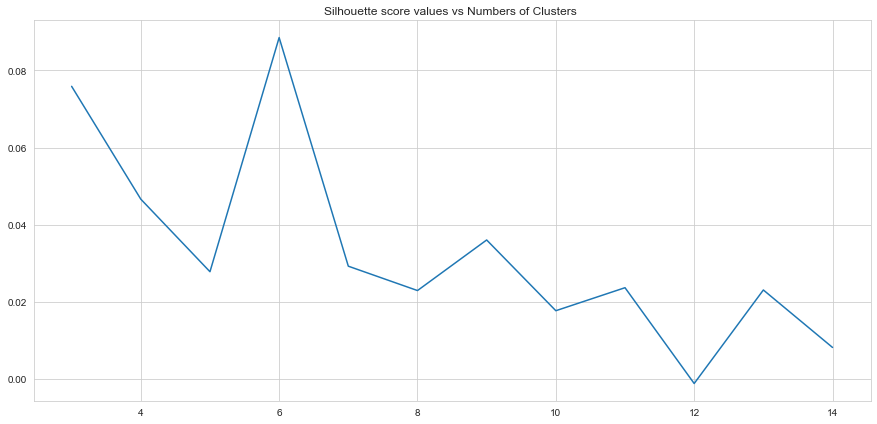

K with highest score
6


In [103]:
kcluster = range(3, 15)
result_score = []
plt.figure(figsize = (15, 7))
for ks in kcluster:
    kmeans = KMeans(n_clusters=ks, random_state = 1, algorithm = 'auto').fit(km)
    klabels = kmeans.labels_
    result_score.append(silhouette_score(km, klabels, metric='euclidean'))
plt.plot(kcluster, result_score)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()
print('K with highest score')
print(result_score.index(max(result_score))+3)
k_optimal = result_score.index(max(result_score))+3

In [104]:
kclusters = k_optimal
kmeans = KMeans(n_clusters=kclusters, random_state = 0, algorithm = 'auto').fit(km)
kmeans.labels_

array([2, 2, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2, 0,
       2, 3, 1, 0, 1, 3, 0, 1, 0, 0, 1, 2, 0, 2, 5, 2, 0, 2, 0, 2, 0, 0,
       2, 0, 0, 2, 2, 2, 1, 0, 1, 0, 1, 2, 2, 2, 2, 2, 1, 2, 0, 2, 4, 2,
       0, 1, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 1, 2, 0, 0,
       2, 5, 2, 0, 5, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 5, 2, 2, 0, 2, 2, 2,
       1, 2, 2, 2, 0, 2, 1, 0, 3, 0, 2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0,
       0, 0, 0, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0,
       0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0,
       2, 2, 2, 2, 5, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0,
       2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2,
       2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 0, 2, 5, 1, 2, 0])

In [105]:
top.insert(0, 'Cluster Labels', kmeans.labels_)
an_df = df
an_df = an_df.merge(top,left_on = 'Station', right_on = 'Station', how = 'left')

In [111]:
map_clusters_metro = folium.Map(location=location.latlng, zoom_start = 11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(an_df['Latitude'], an_df['Longitude'], an_df['Station'], an_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters_metro)
       
map_clusters_metro

In [117]:
# Put all cluster dfs into list
clusters = []
for k in range(0,kclusters):
    clusters.append(an_df.loc[
   an_df['Cluster Labels'] == k,
   an_df.columns[[0,]+ list(range(4, an_df.shape[1]))]])

### Cluster exploration and analysis

##### First, let's look at the distribution of stations by cluster and the spread of prices in each cluster.

In [118]:
venue_count = pd.merge(onehot.groupby('Station').sum(),an_df[['Station','Cluster Labels']],left_on='Station', right_on='Station',how='inner')
venue_count = venue_count.iloc[:,1:].groupby('Cluster Labels').sum().T

cluster_shapes = [cluster.shape[0] for cluster in clusters]
cluster_numbers = np.arange(len(cluster_shapes))

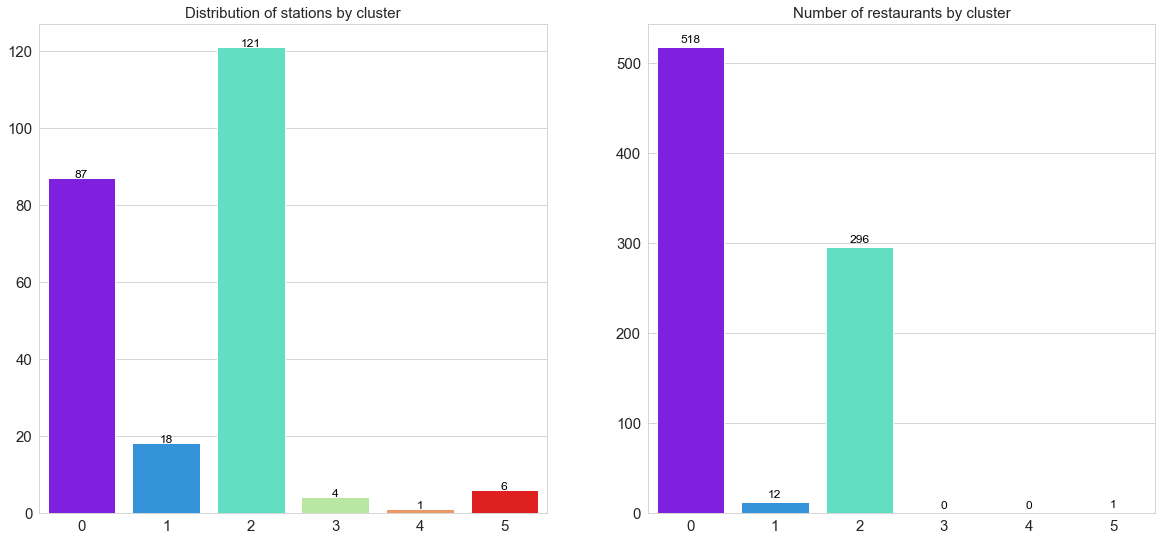

In [119]:
fig = plt.figure(figsize = (20,9))
ax1 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)

ax1 = sns.barplot(x = cluster_numbers, y = cluster_shapes, ci = None, ax = ax1, palette = rainbow)
ax3 = sns.barplot(x =venue_count.loc['Restaurant'].index, y = venue_count.loc['Restaurant'].values, palette = rainbow)

ax1.set_title('Distribution of stations by cluster', fontsize = 15)
ax1.tick_params(axis = 'both', labelsize = 15)
for xtick in ax1.get_xticks():
    ax1.text(xtick, cluster_shapes[xtick]+0.2, cluster_shapes[xtick], horizontalalignment='center',size=12,color='black')

ax3.set_title('Number of restaurants by cluster', fontsize =15)
ax3.set_xlabel('')
ax3.tick_params(axis = 'both', labelsize = 15)
for xtick in ax3.get_xticks():
    ax3.text(xtick,venue_count.loc['Restaurant'].values[xtick]+5,  int(venue_count.loc['Restaurant'].values[xtick]), horizontalalignment='center',size=12,color='black')
plt.show()

##### Looking at the charts, we can note one cluster with a huge number of restaurants. This is cluster 0, which consists of only 87 stations, but contains 518 restaurants. It is obvious that the metro station areas of this cluster are not suitable for opening a restaurant, so this cluster will not be analyzed in detail. For сluster 2, which contains 121 stations and 296 restaurants, you need to find out the number of other establishments.   

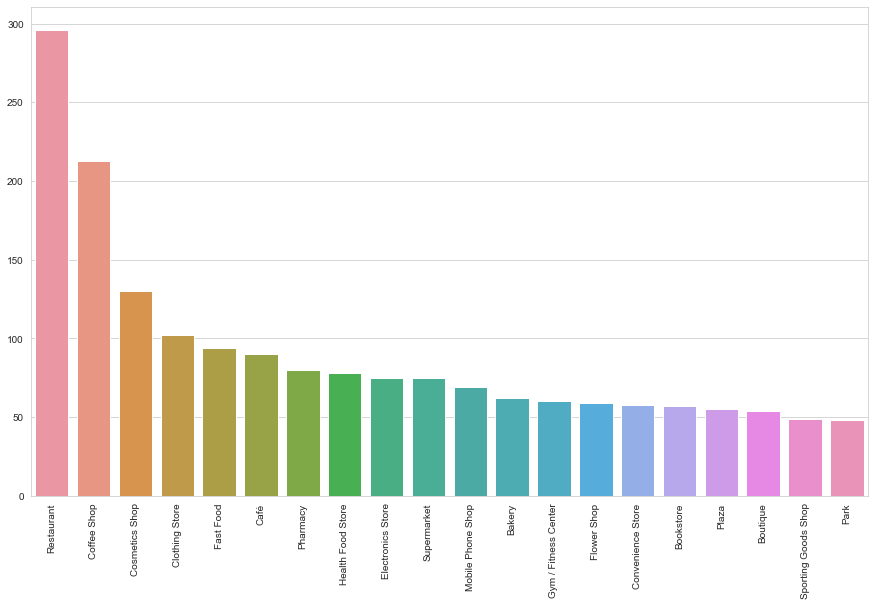

In [120]:
def plotter(num):
    fig = plt.figure(figsize = (15, 9))
    sns.set_style('whitegrid')
    df = venue_count[num].drop(venue_count[venue_count[num]==0].index)
    df= df.sort_values(ascending = False).head(20)
    chart = sns.barplot(x=df.index, y=df.values)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
plotter(2)

##### Despite the smaller number of restaurants, the number of other establishments, such as cafes and coffee shops, makes the station areas of this cluster unsuitable for opening a restaurant

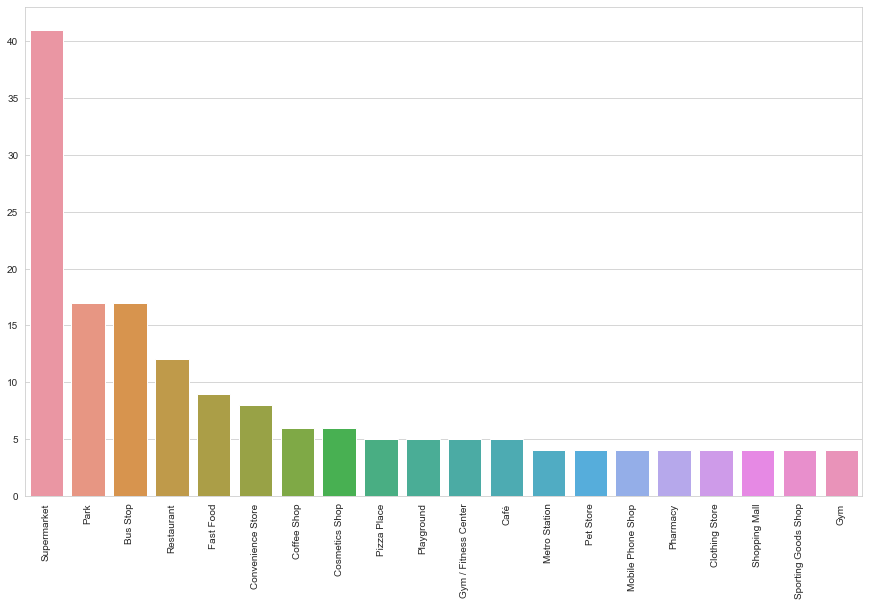

In [121]:
plotter(1)

##### Cluster 1 has only 18 stations and 12 restaurants. The number of other food venues is also small. I think it's worth selecting stations from the cluster that don't have restaurants in their vicinity

In [122]:
def no_restaurants(df):
    mask = ~df.iloc[:, 2:].apply(lambda x: x.str.contains('Restaurant'))
    idxs = mask.all(axis = 1)
    return df.loc[idxs[idxs == True].index.to_list()]
no_rest_1 = no_restaurants(clusters[1])
no_rest_1

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Khovrino,1,Supermarket,Metro Station,Park,Skate Park,Shawarma Place,Gym,Auto Workshop,Campground,Bus Station,Food & Drink Shop
24,Belomorskaya,1,Park,Supermarket,Playground,Brewery,Fruit & Vegetable Store,Flower Shop,Film Studio,Financial or Legal Service,Fish Market,Fishing Store
46,Alma-Atinskaya,1,Gym,Playground,Metro Station,Tennis Stadium,Health Food Store,Supermarket,Arts & Crafts Store,Park,Convenience Store,Pharmacy
128,Novoperedelkino,1,Supermarket,Electronics Store,Mobile Phone Shop,Gym / Fitness Center,Grocery Store,Fast Food,Coffee Shop,Baby Store,Playground,Shoe Store
129,Borovskoye Shosse,1,Food & Drink Shop,Metro Station,Betting Shop,Notary,Shipping Store,Bus Stop,Supermarket,Shopping Mall,Bistro,Flea Market
131,Govorovo,1,Bus Stop,Performing Arts Venue,Wine Shop,Lake,Supermarket,Pub,Bakery,Auto Workshop,Zoo Exhibit,Food
132,Ozyornaya,1,Supermarket,Café,Auto Workshop,Park,Pedestrian Plaza,Health & Beauty Service,Clothing Store,Bus Stop,Spa,Pizza Place
172,Fonvizinskaya,1,Supermarket,Brewery,Pool Hall,Gym / Fitness Center,Clothing Store,Sauna / Steam Room,Fast Food,Pharmacy,Gas Station,Food Court
188,Borisovo,1,Convenience Store,Bus Stop,Supermarket,Playground,Metro Station,Tennis Court,Coffee Shop,Tree,Park,Gym
229,Lefortovo,1,Park,Bus Stop,Beer Store,Movie Theater,Pub,Cosmetics Shop,Supermarket,Warehouse Store,Toy / Game Store,Plaza


##### Clusters 3, 4, and 5 remain. Let's look at cluster 3

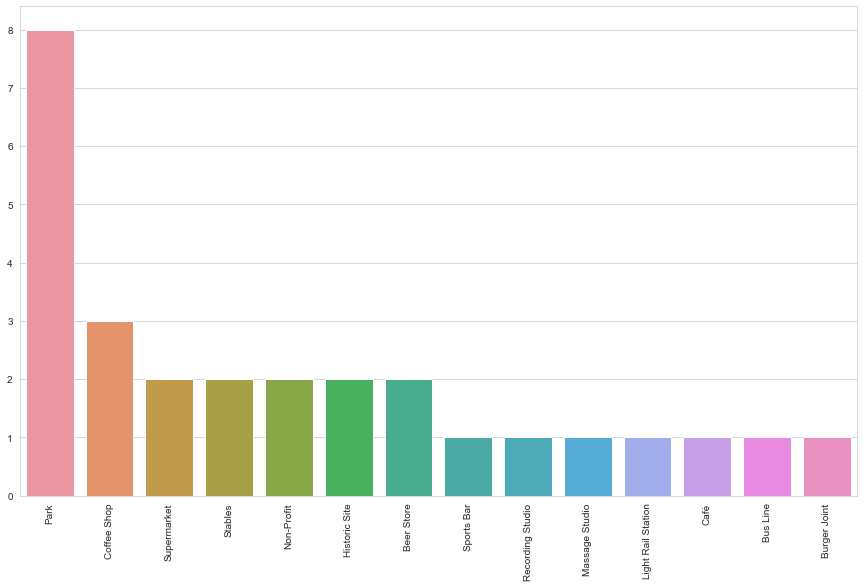

In [123]:
plotter(3)

##### Many parks, two historic sites and no restaurants, These metro station areas looks good for opening new restaurant
##### Cluster 4, which consists of only one station

In [124]:
clusters[4]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Kommunarka,4,Metro Station,Zoo Exhibit,Food,Field,Film Studio,Financial or Legal Service,Fish Market,Fishing Store,Flea Market,Flower Shop


##### No any cafes or restaurants. This station area can be a good place for open new restaurant
##### And cluster 5

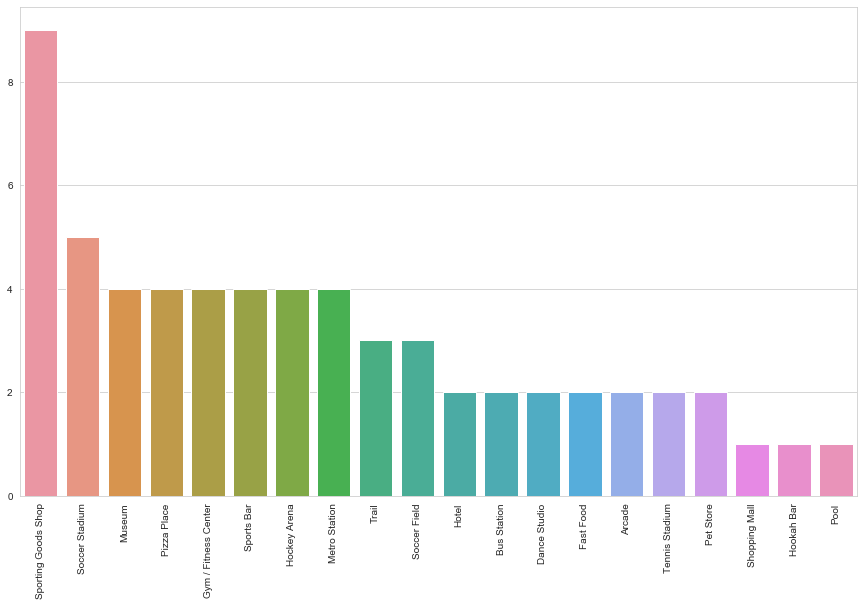

In [125]:
plotter(5)

##### There are many sports facilities, but there are also museums and just one restaurant...

In [126]:
clusters[5]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Cherkizovskaya,5,Sporting Goods Shop,Gym / Fitness Center,Pizza Place,Soccer Stadium,Soccer Field,Sports Bar,Bus Station,Museum,Tennis Stadium,Metro Station
109,Spartak,5,Soccer Stadium,Sports Bar,Fast Food,Museum,Sandwich Place,Sporting Goods Shop,Metro Station,Restaurant,Food Court,Food & Drink Shop
136,Minskaya,5,Trail,Museum,Gas Station,Furniture / Home Store,Fruit & Vegetable Store,Field,Film Studio,Financial or Legal Service,Fish Market,Fishing Store
210,Lokomotiv,5,Sporting Goods Shop,Gym / Fitness Center,Soccer Stadium,Dance Studio,Café,Hockey Arena,Pet Store,Museum,Metro Station,Sports Bar
217,ZIL,5,Sporting Goods Shop,Hockey Arena,Park,Pool,Zoo Exhibit,Flea Market,Field,Film Studio,Financial or Legal Service,Fish Market
235,Lukhmanovskaya,5,Metro Station,Pizza Place,Fast Food,Shopping Mall,Flea Market,Farmers Market,Field,Film Studio,Financial or Legal Service,Fish Market


##### ...which is located at Spartak station, it's possible to exclude this station from the selection

In [127]:
no_rest_5 = no_restaurants(clusters[5])

##### Now i can compare the selected stations by price and passenger traffic levels

In [205]:
possible_good = pd.concat([no_rest_1, clusters[3], clusters[4], no_rest_5])
possible_good = possible_good.merge(df, left_on = 'Station', right_on = 'Station')
possible_good = possible_good.merge(price_df[['Russian','Price(RUR/sqm)']], left_on = 'Russian', right_on = 'Russian', how = 'left')
possible_good = possible_good.merge(traffic_df, left_on = 'Russian', right_on = 'Russian', how = 'left')
for col in ['Longitude','Latitude','Price(RUR/sqm)','Traffic','Russian']:
    to_first = possible_good.pop(col)
    possible_good.insert(1, col, to_first)

In [206]:
possible_good_nan = possible_good[possible_good.isnull().T.any().T]
possible_good_nan

,Station,Russian,Traffic,Price(RUR/sqm),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Khovrino,Ховрино,NaN,195074.0,55.8791,37.4822,1,Supermarket,Metro Station,Park,Skate Park,Shawarma Place,Gym,Auto Workshop,Campground,Bus Station,Food & Drink Shop
1,Belomorskaya,Беломорская,NaN,195721.0,55.8658,37.4764,1,Park,Supermarket,Playground,Brewery,Fruit & Vegetable Store,Flower Shop,Film Studio,Financial or Legal Service,Fish Market,Fishing Store
4,Borovskoye Shosse,Боровское Шоссе,NaN,NaN,55.6476,37.3701,1,Food & Drink Shop,Metro Station,Betting Shop,Notary,Shipping Store,Bus Stop,Supermarket,Shopping Mall,Bistro,Flea Market
6,Ozyornaya,Озёрная,NaN,NaN,55.6709,37.4491,1,Supermarket,Café,Auto Workshop,Park,Pedestrian Plaza,Health & Beauty Service,Clothing Store,Bus Stop,Spa,Pizza Place
7,Fonvizinskaya,Фонвизинская,NaN,192784.0,55.8228,37.5881,1,Supermarket,Brewery,Pool Hall,Gym / Fitness Center,Clothing Store,Sauna / Steam Room,Fast Food,Pharmacy,Gas Station,Food Court
9,Lefortovo,Лефортово,NaN,NaN,55.7649,37.7051,1,Park,Bus Stop,Beer Store,Movie Theater,Pub,Cosmetics Shop,Supermarket,Warehouse Store,Toy / Game Store,Plaza
10,Nekrasovka,Некрасовка,NaN,133680.0,55.7036,37.9264,1,Supermarket,Café,Convenience Store,Fast Food,Food & Drink Shop,Zoo Exhibit,Film Studio,Financial or Legal Service,Fish Market,Fishing Store
17,Minskaya,Минская,NaN,264387.0,55.7246,37.4970,5,Trail,Museum,Gas Station,Furniture / Home Store,Fruit & Vegetable Store,Field,Film Studio,Financial or Legal Service,Fish Market,Fishing Store
18,Lokomotiv,Локомотив,NaN,NaN,55.8039,37.7460,5,Sporting Goods Shop,Gym / Fitness Center,Soccer Stadium,Dance Studio,Café,Hockey Arena,Pet Store,Museum,Metro Station,Sports Bar
19,ZIL,ЗИЛ,NaN,NaN,55.6983,37.6483,5,Sporting Goods Shop,Hockey Arena,Park,Pool,Zoo Exhibit,Flea Market,Field,Film Studio,Financial or Legal Service,Fish Market


##### Since there are not many stations with NaN, I can replace the spaces in the data manually

In [207]:
traffics = [30000,32000,60000,70000,55000,135000,48000, 8700,21000,5000,32000]
for ind,traffic in zip(possible_good_nan.index.tolist(), traffics):
    possible_good.iloc[ind, 2] = traffic

In [208]:
possible_good_nan = possible_good[possible_good.isnull().T.any().T]

In [209]:
prices = [231302, 187220, 249595, 308000, 202800]
for ind,price in zip(possible_good_nan.index.tolist(), prices):
    possible_good.iloc[ind, 3] = price

In [210]:
possible_good = possible_good.merge(distr_df, left_on = 'Russian', right_on = 'Russian', how = 'left')
possible_good = possible_good.merge(eco_df[['District', 'Rating']], left_on = 'District', right_on = 'District', how = 'left')

In [211]:
possible_good[possible_good.isnull().T.any().T]

,Station,Russian,Traffic,Price(RUR/sqm),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District,Rating
5,Govorovo,Говорово,70000.0,161032.0,55.6595,37.4172,1,Bus Stop,Performing Arts Venue,Wine Shop,Lake,Supermarket,Pub,Bakery,Auto Workshop,Zoo Exhibit,Food,районе,NaN


In [212]:
possible_good.iloc[5, [-2, -1]] = 'Говорово', 1 # this district placed near another district with eco-rating value = 1

In [213]:
possible_good = possible_good.drop(columns = 'Cluster Labels')
to_first = possible_good.pop('Rating')
possible_good.insert(1, 'Rating', to_first)
possible_good_show = possible_good.iloc[:, :5].sort_values(by = ['Rating','Price(RUR/sqm)']).reset_index(drop = True)
possible_good_show

,Station,Rating,Russian,Traffic,Price(RUR/sqm)
0,Govorovo,1,Говорово,70000.0,161032.0
1,Nekrasovka,1,Некрасовка,48000.0,133680.0
2,Lukhmanovskaya,1,Лухмановская,32000.0,137442.0
3,Cherkizovskaya,1,Черкизовская,25900.0,159078.0
4,Ozyornaya,1,Озёрная,70000.0,187220.0
5,Fonvizinskaya,1,Фонвизинская,55000.0,192784.0
6,ZIL,1,ЗИЛ,5000.0,202800.0
7,Lefortovo,1,Лефортово,135000.0,249595.0
8,Borisovo,2,Борисово,25600.0,145388.0
9,Alma-Atinskaya,2,Алма-Атинская,29700.0,146722.0


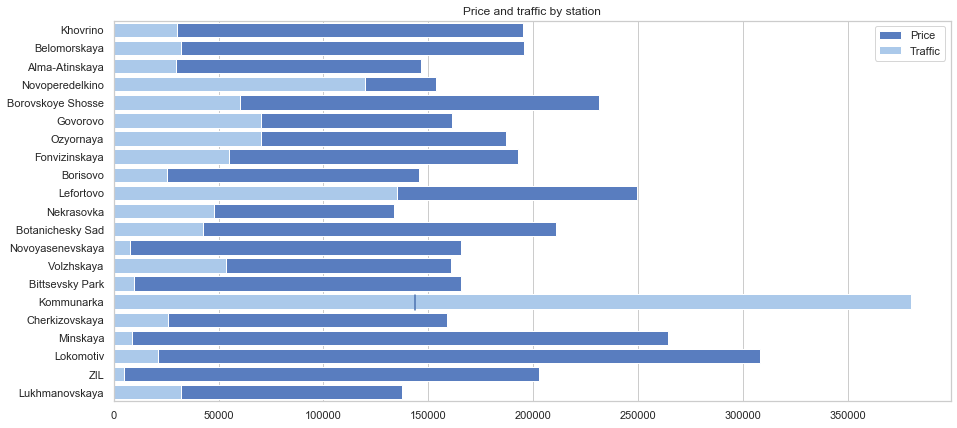

In [216]:
price_kommun = possible_good[possible_good['Station'] == 'Kommunarka']['Price(RUR/sqm)'].values
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(15, 7))
sns.set_color_codes('muted')
ax1 = sns.barplot(x='Price(RUR/sqm)', y='Station', data=possible_good, color = 'b', label = 'Price')
sns.set_color_codes('pastel')
ax2 = sns.barplot(x='Traffic', y='Station', data=possible_good, color = 'b', label = 'Traffic')
ax.set(ylabel = '', xlabel = '')
plt.axvline(price_kommun, 0.24, 0.28)
ax.set_title('Price and traffic by station')
ax.legend()
plt.show()

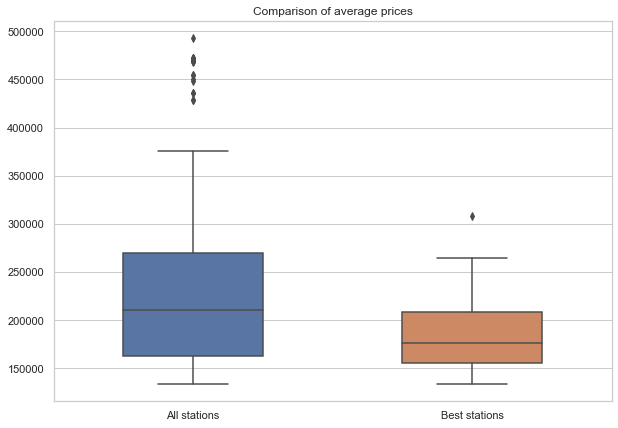

Mean, max and min prices for all stations is 235753.05660377358 , 492846.0 , 133680.0
Mean, max and min prices for resulting stations is 187321.45454545456 , 308000.0 , 133680.0


In [217]:
fb, axb = plt.subplots(figsize=(10, 7))
ax = sns.boxplot( data = [price_df['Price(RUR/sqm)'], possible_good['Price(RUR/sqm)']], width = 0.5)
ax.set_xticks([0,1])
ax.set_xticklabels(['All stations', 'Best stations'])
ax.set_title('Comparison of average prices')
plt.show()
a = price_df['Price(RUR/sqm)'].mean()
a1 = price_df['Price(RUR/sqm)'].max()
a2 = price_df['Price(RUR/sqm)'].min()
b = possible_good['Price(RUR/sqm)'].mean()
c = possible_good['Price(RUR/sqm)'].max()
d = possible_good['Price(RUR/sqm)'].min()
print('Mean, max and min prices for all stations is', a, ',', a1, ',', a2)
print('Mean, max and min prices for resulting stations is', b, ',', c,',', d)

### Final map

In [218]:
clrs = ['red', 'orange', 'yellow', 'green']
# Creating a map and adding markers to it
map_metro_good = folium.Map(location=location.latlng, zoom_start=10)


for lat, lng, metro, rating, price, traf in zip(possible_good['Latitude'],
                                                possible_good['Longitude'], 
                                                possible_good['Station'], 
                                                possible_good['Rating'], 
                                                possible_good['Price(RUR/sqm)'],
                                                possible_good['Traffic']):
    label = '{}, Eco rate {}, {} RUR/sqm, {}'.format(metro, rating, price, traf)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=clrs[int(rating) - 1],
        fill=True,
        fill_color=clrs[int(rating) - 1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_metro_good) 
    
    
map_metro_good